# Creating random training data polygons

Using Collect Earth Online (CEO), these randomly scattered polygons will be classified as crop, non-crop, or mixed and form the knowledge base for the machine learning classifier.

Using GEOGLAM's current crop-mask (ASAP) to stratify the points

### Load modules

In [2]:
import geopandas as gpd
from datacube.utils.cog import write_cog
import xarray as xr
import numpy as np
import pandas as pd

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

### Analysis Parameters

In [3]:
asap_crop_mask = 'data/asap_mask_crop_v03.tif'

#AEZ to mask crop mask
aez = 'data/AEZs/Southern.shp'

#location and file name to store shapefiles.
out_fname = 'data/training_validation/collect_earth/Southern_TD'

### Open datasets

In [4]:
crop_mask = xr.open_rasterio(asap_crop_mask).squeeze()

aez = gpd.read_file(aez)

### Mask by AEZ

In [5]:
aez_raster = xr_rasterize(aez, crop_mask)
crop_mask_aez = crop_mask.where(aez_raster, drop=True)

Rasterizing to match xarray.DataArray dimensions (14673, 40320) and projection system/CRS (e.g. +init=epsg:4326)


### Reclassify

Pixels in the ASAP cropmask refer to the percentage of crop in each pixel, scaled to 0-200.  Reclassifying so values >100 (i.e. 50% crop) are labelled as '2', values between 1-100 are labelled as '1', and 0 stays as 0.

In [6]:
crop_mask_aez = xr.where((crop_mask_aez >=1) & (crop_mask_aez <= 100), 1, crop_mask_aez)
crop_mask_aez = xr.where(crop_mask_aez > 100, 2, crop_mask_aez)

#add back attributes
crop_mask_aez.attrs = crop_mask.attrs

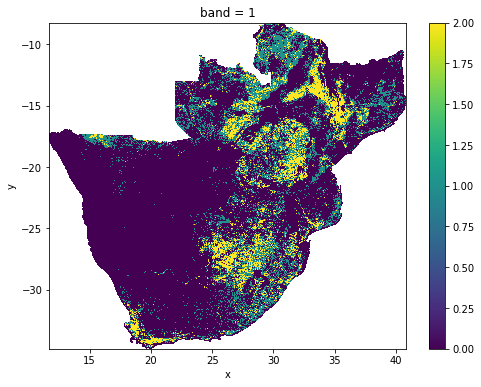

In [7]:
crop_mask_aez.plot(figsize=(8,6))

### Generate random points

2000 random points: 50% (1000) in 2, 25% (500) in 1, 25% (500) in 0

In [10]:
gdf = random_sampling(crop_mask_aez,
                     n=2000,
                     sampling='manual',
                     manual_class_ratios={'0.0':500, '1.0':500, '2.0':1000})

Class 0.0: sampled at 500 coordinates
Class 1.0: sampled at 500 coordinates
Class 2.0: sampled at 1000 coordinates


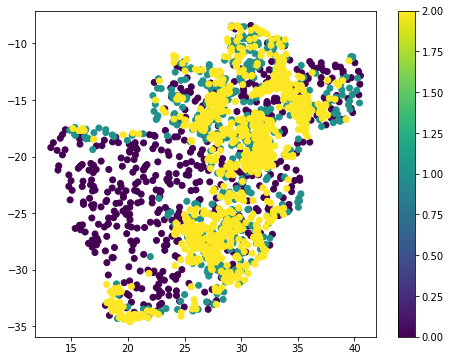

In [12]:
#export as points and then plot
gdf.to_file(out_fname + '_points.shp')

gdf.plot(figsize=(8,6), column='class', legend=True)

### Convert points to square polygons

In [13]:
#set radius (in metres) around points
radius = 40

#convert to equal area to set polygon size in metres
gdf = gdf.to_crs('EPSG:6933')

#create circle buffer around points, then find envelope
gdf['geometry'] = gdf['geometry'].buffer(radius).envelope

In [14]:
#export to file
gdf.to_file(out_fname + '_polys.shp')

In [9]:
def random_sampling(da,
                    n,
                    sampling='stratified_random',
                    manual_class_ratios=None,
                    out_fname=None
                   ):
    
    """
    Creates randomly sampled points for post-classification
    accuracy assessment.
    
    Params:
    -------
    da: xarray.DataArray
        A classified 2-dimensional xarray.DataArray
    n: int
        Total number of points to sample. Ignored if providing
        a dictionary of {class:numofpoints} to 'manual_class_ratios'
    sampling: str
        'stratified_random' = Create points that are randomly 
        distributed within each class, where each class has a
        number of points proportional to its relative area. 
        'equal_stratified_random' = Create points that are randomly
        distributed within each class, where each class has the
        same number of points.
        'random' = Create points that are randomly distributed
        throughout the image.
        'manual' = user definined, each class is allocated a 
        specified number of points, supply a manual_class_ratio 
        dictionary mapping number of points to each class
    manual_class_ratios: dict
        If setting sampling to 'manual', the provide a dictionary
        of type {'class': numofpoints} mapping the number of points
        to generate for each class.
    out_fname: str
        If providing a filepath name, e.g 'sample_points.shp', the
        function will export a shapefile/geojson of the sampling
        points to file.
    
    Output
    ------
    GeoPandas.Dataframe
    
    """
    
    if sampling not in ['stratified_random', 'equal_stratified_random', 'random', 'manual']:
        raise ValueError("Sampling strategy must be one of 'stratified_random', "+
                             "'equal_stratified_random', 'random', or 'manual'") 
    
    #open the dataset as a pandas dataframe
    da = da.squeeze()
    df = da.to_dataframe(name='class')
    
    #list to store points
    samples = []
    
    if sampling == 'stratified_random':
        #determine class ratios in image
        class_ratio = pd.DataFrame({'proportion': df['class'].value_counts(normalize=True),
                            'class':df['class'].dropna().unique()
                                 })
        
        for _class in class_ratio['class']:
            #use relative proportions of classes to sample df
            no_of_points = n * class_ratio[class_ratio['class']==_class]['proportion'].values[0]
            #random sample each class
            print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
            sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
            samples.append(sample_loc)

    if sampling == 'equal_stratified_random':
        classes = df['class'].dropna().unique()
        
        for _class in classes:
            #use relative proportions of classes to sample df
            no_of_points = n / len(classes)
            #random sample each classes
            try:
                sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
                print('Class '+ str(_class)+ ': sampling at '+ str(round(no_of_points)) + ' coordinates')
                samples.append(sample_loc)
            
            except ValueError:
                        print('Requested more sample points than population of pixels for class '+ str(_class)+', skipping')
                        pass
    
    if sampling == 'random':
        no_of_points = n
        #random sample entire df
        print('Randomly sampling dataAraay at '+ str(round(no_of_points)) + ' coordinates')
        sample_loc = df.dropna().sample(n=int(round(no_of_points)))
        samples.append(sample_loc)
    
    if sampling == 'manual':
        if isinstance(manual_class_ratios, dict):
            #check classes in dict match classes in data
            classes = df['class'].dropna().unique()
            dict_classes = list(manual_class_ratios.keys())
            
            if set(dict_classes).issubset([str(i) for i in classes]):
                #mask for just those classes in the provided dictionary
                mask = np.isin(classes,
                               np.array(dict_classes).astype(type(classes[0])))
                classes = classes[mask]               
                #run sampling
                for _class in classes:
                    no_of_points = manual_class_ratios.get(str(_class))
                    #random sample each class
                    try:
                        sample_loc = df[df['class'] == _class].sample(n=int(round(no_of_points)))
                        print('Class '+ str(_class)+ ': sampled at '+ str(round(no_of_points)) + ' coordinates')
                        samples.append(sample_loc)
                        
                    except ValueError:
                        print('Requested more sample points than population of pixels for class '+ str(_class)+', skipping')
                        pass

            else:
                raise ValueError("Some or all of the classes in 'manual_class_ratio' dictionary do not" +
                                 " match the classes in the supplied dataArray. "+
                                "DataArray classes: "+str(classes)+", Supplied dict classes: "+
                                 str(list(manual_class_ratios.keys())))
            
        else:
            raise ValueError("Must supply a dictionary mapping {'class': numofpoints} if sampling" +
                             " is set to 'manual'")
    
    #join back into single datafame
    all_samples = pd.concat([samples[i] for i in range(0,len(samples))])
        
    #get pd.mulitindex coords as list 
    y = [i[0] for i in list(all_samples.index)]
    x = [i[1] for i in list(all_samples.index)]

    #create geopandas dataframe
    gdf = gpd.GeoDataFrame(
        all_samples,
        crs=da.crs,
        geometry=gpd.points_from_xy(x,y)).reset_index()

    gdf = gdf.drop(['x', 'y'],axis=1)
    
    if out_fname is not None:
        gdf.to_file(out_fname)
    
    return gdf